# GradScope

>#### GradScope is a predictive model that accurately predicts whether a student will be admitted based on their academic profile such as
- standardized test scores
- university rating
- CGPA
- Research background.

### Importing necessary libraries

In [129]:
#============Data Manipulation and processing=========#
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#==========Data Visualization=======================#
import matplotlib.pyplot as plt
import seaborn as sns
#==========Ignore unecessary warnings===============#
import warnings
warnings.filterwarnings("ignore")
#===========Model Development=======================#
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay, confusion_matrix
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

## Helper Functions

>#### Calculate Class weights to address class imbalance

In [6]:
def calculate_class_weights(y):
    #Function to calculate class weights based on class distribution in the target variable.
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

>#### Function to plot the confusion matrix for the model to evaluate preformance

In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(8, 6)):

    #Visualize the confusion matrix for model evaluation.

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


>#### Kfold cross-validation

In [12]:
def stratified_kfold_cv(model, X, y, n_splits=None, class_weights=None, verbose=False):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=65)
    f1_scores = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        if verbose:
            print(f"Fold {fold+1}/{n_splits}")

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the model with class weights if provided
        if class_weights:
            model.set_params(class_weight=class_weights)

        model.fit(X_train, y_train)

        # Make predictions and evaluate F1 score
        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds)
        f1_scores.append(f1)
        
        if verbose:
            print(f"F1 Score: {f1:.4f}")

    mean_f1_score = np.mean(f1_scores)
    if verbose:
        print(f"Mean F1 Score: {mean_f1_score:.4f}")

    return mean_f1_score


>#### Visualize Feature Importance

In [15]:
def visualize_feature_importance(model, feature_names, top_n=None):

    # Extract feature importances
    importance = model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    top_features = importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
    plt.show()


## Data Ingestion

In [18]:
#Load the datasets
data1 = pd.read_csv(r"C:\Users\HP\Desktop\Zindi ML projects\Grad school ML Challenge\train.csv")
data2 = pd.read_csv(r"C:\Users\HP\Desktop\Zindi ML projects\Grad school ML Challenge\test.csv")
sub = pd.read_csv(r"C:\Users\HP\Desktop\Zindi ML projects\Grad school ML Challenge\SampleSubmission.csv")

display("Grad_school train data", data1.head(), "Grad_school test_data", data2.head(), "sample_sub", sub.head())

'Grad_school train data'

,ID,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admitted,Age,Location,First_Generation
0,ID_000001,319.0,111.0,4,4.78,4.89,9.51,1,1,26,South America,1
1,ID_000002,327.0,113.0,5,4.24,4.74,10.19,1,1,23,Africa,1
2,ID_000003,323.0,110.0,4,3.43,2.99,8.81,1,1,32,South America,0
3,ID_000004,321.0,105.0,3,3.41,3.38,NaN,0,0,34,Africa,1
4,ID_000005,316.0,108.0,3,NaN,4.80,NaN,1,1,30,North America,1


'Grad_school test_data'

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Age,Location,First_Generation,ID
0,323.0,110.0,3,3.49,3.72,9.50,1,24,South America,0,ID_003601
1,324.0,111.0,4,4.32,3.84,8.86,1,23,Asia,0,ID_003602
2,311.0,104.0,2,4.38,1.84,7.21,1,24,Asia,1,ID_003603
3,323.0,109.0,4,4.92,3.81,10.00,1,27,North America,0,ID_003604
4,321.0,111.0,4,4.00,5.99,8.59,1,29,North America,1,ID_003605


'sample_sub'

,ID,Admitted
0,ID_003601,0
1,ID_003602,0
2,ID_003603,0
3,ID_003604,0
4,ID_003605,0


In [20]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 3600 non-null   object 
 1   GRE Score          3240 non-null   float64
 2   TOEFL Score        3240 non-null   float64
 3   University Rating  3600 non-null   int64  
 4   SOP                3240 non-null   float64
 5   LOR                3600 non-null   float64
 6   CGPA               3240 non-null   float64
 7   Research           3600 non-null   int64  
 8   Admitted           3600 non-null   int64  
 9   Age                3600 non-null   int64  
 10  Location           3600 non-null   object 
 11  First_Generation   3600 non-null   int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 337.6+ KB


In [22]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          810 non-null    float64
 1   TOEFL Score        810 non-null    float64
 2   University Rating  900 non-null    int64  
 3   SOP                810 non-null    float64
 4   LOR                900 non-null    float64
 5   CGPA               810 non-null    float64
 6   Research           900 non-null    int64  
 7   Age                900 non-null    int64  
 8   Location           900 non-null    object 
 9   First_Generation   900 non-null    int64  
 10  ID                 900 non-null    object 
dtypes: float64(5), int64(4), object(2)
memory usage: 77.5+ KB


>#### Descriptive Statistics

In [25]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,3240.0,315.670370,11.182755,289.00,307.00,316.00,324.00,341.00
TOEFL Score,3240.0,106.384877,6.210148,90.00,102.00,106.00,111.00,121.00
University Rating,3600.0,2.880000,1.087216,1.00,2.00,3.00,4.00,5.00
SOP,3240.0,3.373710,1.244215,-0.51,2.53,3.40,4.29,7.07
LOR,3600.0,3.430964,1.192197,-0.64,2.60,3.46,4.28,7.22
CGPA,3240.0,8.576917,0.987162,5.33,7.89,8.60,9.25,12.84
Research,3600.0,0.455000,0.498040,0.00,0.00,0.00,1.00,1.00
Admitted,3600.0,0.665278,0.471959,0.00,0.00,1.00,1.00,1.00
Age,3600.0,27.387778,4.624213,20.00,23.00,27.00,31.00,35.00
First_Generation,3600.0,0.494444,0.500039,0.00,0.00,0.00,1.00,1.00


In [27]:
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE Score,810.0,315.353086,11.471199,291.00,307.0000,315.000,324.0000,341.00
TOEFL Score,810.0,106.300000,6.027758,91.00,102.0000,106.000,111.0000,120.00
University Rating,900.0,2.877778,1.110450,1.00,2.0000,3.000,4.0000,5.00
SOP,810.0,3.388889,1.199528,-0.05,2.5625,3.390,4.2400,7.15
LOR,900.0,3.504111,1.171153,0.25,2.6475,3.525,4.3225,6.72
CGPA,810.0,8.525333,1.014719,5.67,7.8300,8.515,9.2500,11.52
Research,900.0,0.443333,0.497055,0.00,0.0000,0.000,1.0000,1.00
Age,900.0,27.536667,4.563212,20.00,24.0000,27.000,31.0000,35.00
First_Generation,900.0,0.463333,0.498931,0.00,0.0000,0.000,1.0000,1.00


In [29]:
data1.isnull().sum()

ID                     0
GRE Score            360
TOEFL Score          360
University Rating      0
SOP                  360
LOR                    0
CGPA                 360
Research               0
Admitted               0
Age                    0
Location               0
First_Generation       0
dtype: int64

#### The descriptive statistics tell us most features follow a normal distribution, the averages (mean) and middle values (median) are close, suggesting balanced data. But digging deeper reveals information that don’t make sense:

>##### SOP & LOR Scores (1–5 Scale)

>##### Should range from 1 (weak) to 5 (excellent).
Yet, some entries show negative scores or values above 5, like a student getting a "7" on an SOP meant to cap at 5.

>##### GRE (Max 340) & TOEFL (Max 120)

>- The data includes scores exceeding these limits (e.g., GRE 341 or TOEFL 121).
>- This scores is impossible for standardized tests with fixed maximums.

>##### CGPA (10-Point Scale)
A few students have CGPA > 10, which defies grading rules.

This messy data could skew predictions. Cleaning it ensures that **GradScope** gets accurate data and will help uncover the real story behind admissions success.

# Data Visualization

>## Exploratory Data Analysis

In [52]:
# Target class distribution
admission_counts = data1['Admitted'].value_counts()
admission_counts

Admitted
1    2395
0    1205
Name: count, dtype: int64

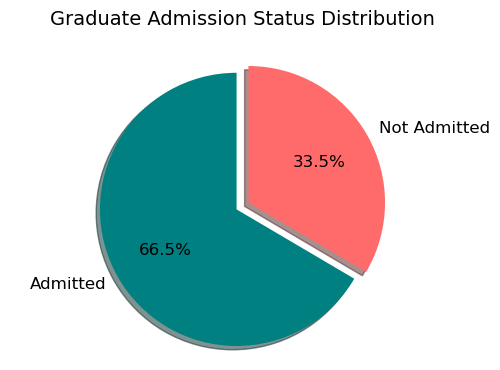

In [54]:
#plot a pie chart to visualize target distribution 
colors = ['#008080', '#FF6B6B'] 
#explodes the most frequent class, in this case the "Admitted" class
explode = (0.1, 0) if admission_counts[0] > admission_counts[1] else (0, 0.1)

plt.figure(figsize=(6, 4))
plt.pie(
    admission_counts,
    labels=['Admitted', 'Not Admitted'], 
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 12}
)

plt.title('Graduate Admission Status Distribution', fontsize=14, pad=20)
plt.axis('equal')
plt.show()

>##### The numbers speak clearly as two-thirds of applicants in this dataset celebrate admission letters. With 66.5% of academic profiles representing successful candidates and 33.5% representing the unsuccessful ones

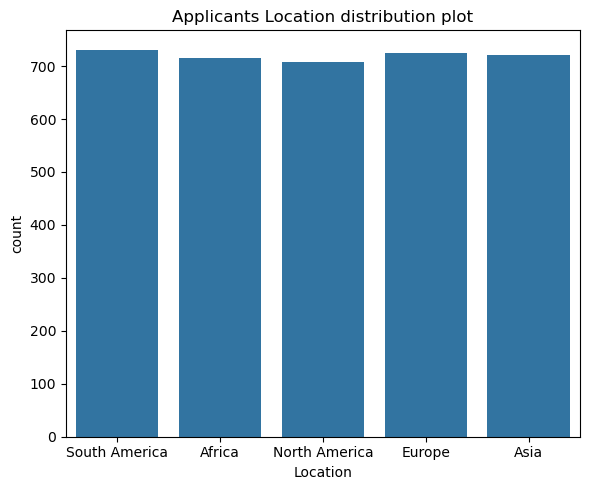

In [58]:
# Visualize location feature distribution

plt.figure(figsize=(6,5))
sns.countplot(x="Location", data=data1)
plt.title("Applicants Location distribution plot")
plt.tight_layout()
plt.show()

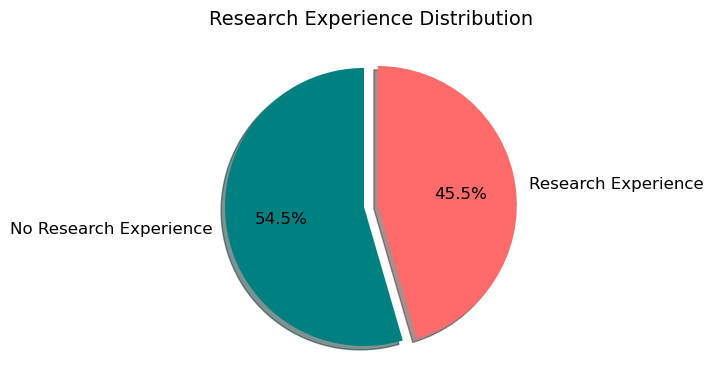

In [68]:
# Visualize Research feature distribution
research_counts = data1['Research'].value_counts()
#plot a pie chart to visualize target distribution 
colors = ['#008080', '#FF6B6B'] 
#explodes the most frequent class, in this case the "Admitted" class
explode = (0.1, 0) if research_counts[0] > research_counts[1] else (0, 0.1)

plt.figure(figsize=(6, 4))
plt.pie(
    research_counts,
    labels=['No Research Experience', 'Research Experience'], 
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 12}
)

plt.title('Research Experience Distribution', fontsize=14, pad=20)
plt.axis('equal')
plt.show()

>#### The plot above reveals a divide in research backgrounds. 54.5% of applicants reported no formal research experience while 45.5% demonstrated research involvement through publications, projects etc.

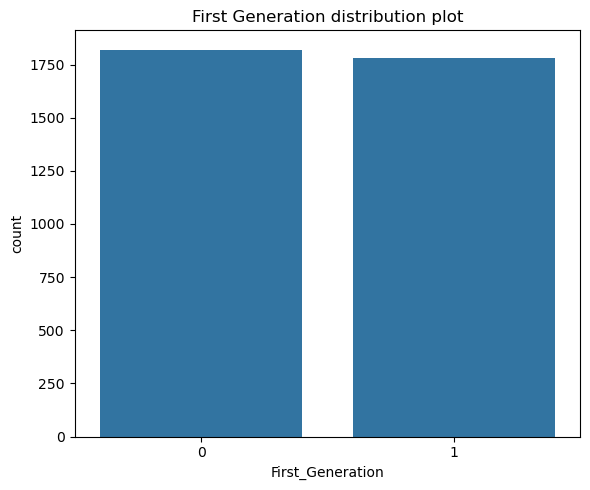

In [72]:
# Visualize first generation feature distribution

plt.figure(figsize=(6,5))
sns.countplot(x="First_Generation", data=data1)
plt.title("First Generation distribution plot")
plt.tight_layout()
plt.show()

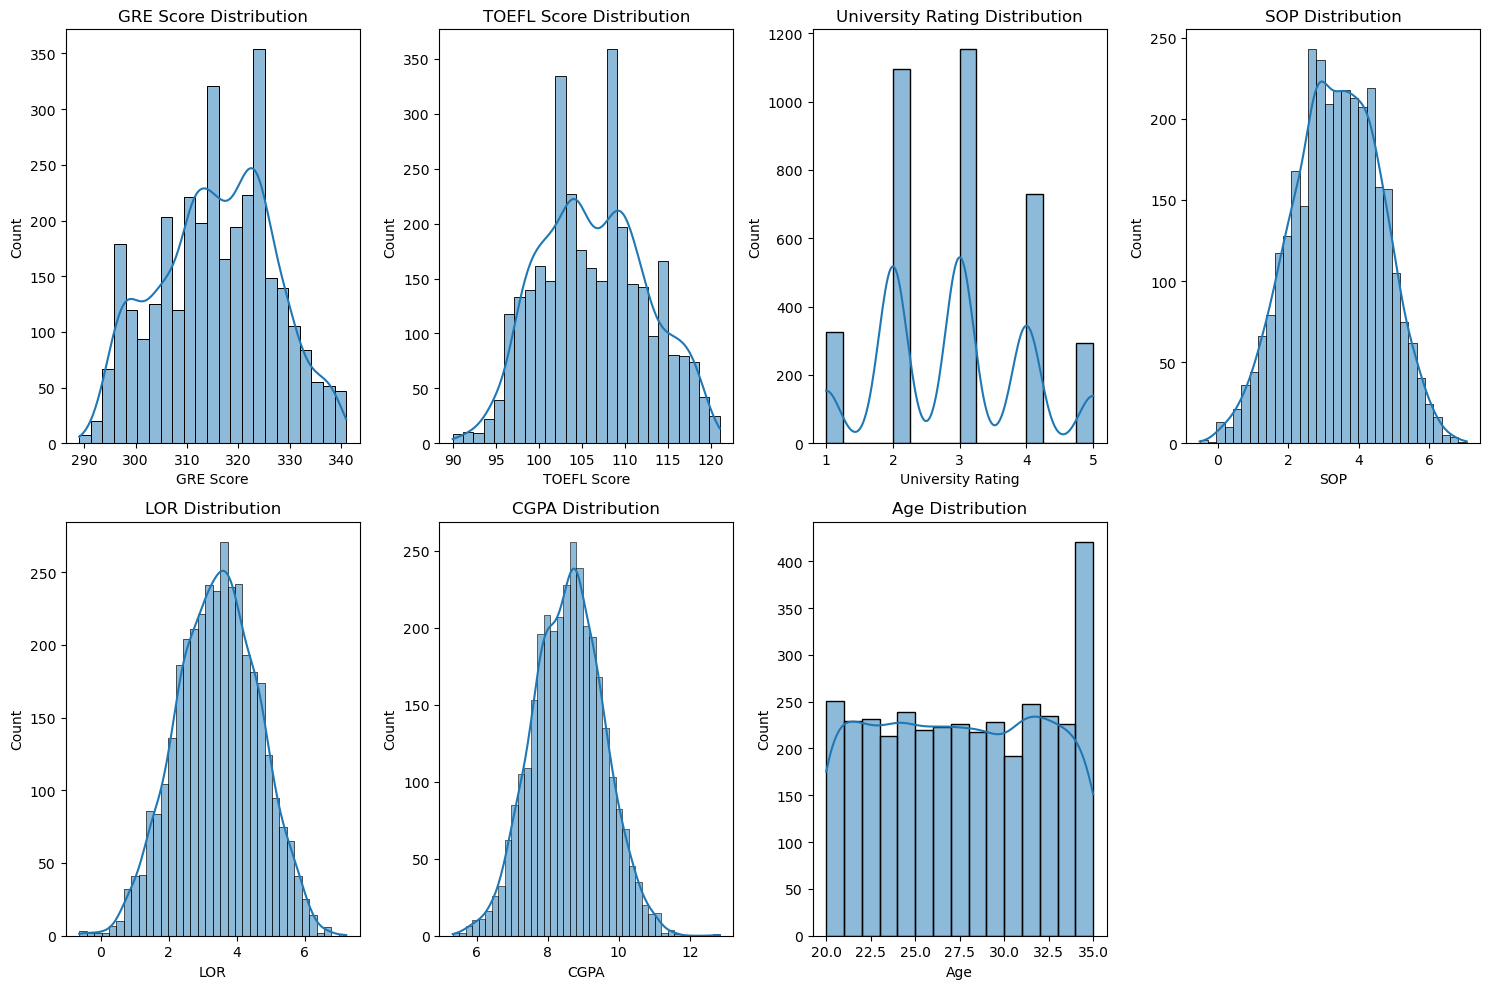

In [74]:
# Visualize numerical features distribution
fig, axes = plt.subplots(2,4, figsize=(15,10))

sns.histplot(data1["GRE Score"], kde=True, ax=axes[0,0])
axes[0,0].set_xlabel("GRE Score")
axes[0,0].set_title("GRE Score Distribution")

sns.histplot(data1["TOEFL Score"], kde=True, ax=axes[0,1])
axes[0,1].set_xlabel("TOEFL Score")
axes[0,1].set_title("TOEFL Score Distribution")

sns.histplot(data1["University Rating"], kde=True, ax=axes[0,2])
axes[0,2].set_xlabel("University Rating")
axes[0,2].set_title("University Rating Distribution")

sns.histplot(data1["SOP"], kde=True, ax=axes[0,3])
axes[0,3].set_xlabel("SOP")
axes[0,3].set_title("SOP Distribution")

sns.histplot(data1["LOR "], kde=True, ax=axes[1,0])
axes[1,0].set_xlabel("LOR")
axes[1,0].set_title("LOR Distribution")

sns.histplot(data1["CGPA"], kde=True, ax=axes[1,1])
axes[1,1].set_xlabel("CGPA")
axes[1,1].set_title("CGPA Distribution")

sns.histplot(data1["Age"], kde=True, ax=axes[1,2])
axes[1,2].set_xlabel("Age")
axes[1,2].set_title("Age Distribution")

axes[1,3].axis("off")
plt.tight_layout()
plt.show()

>#### The distribution plots reveals that 300+ applicants cluster in the 315-325 GRE range, while 350+ score just below 110 on the TOEFL. Over 1,000 applicants favor mid-tier universities (ranks 2-3)

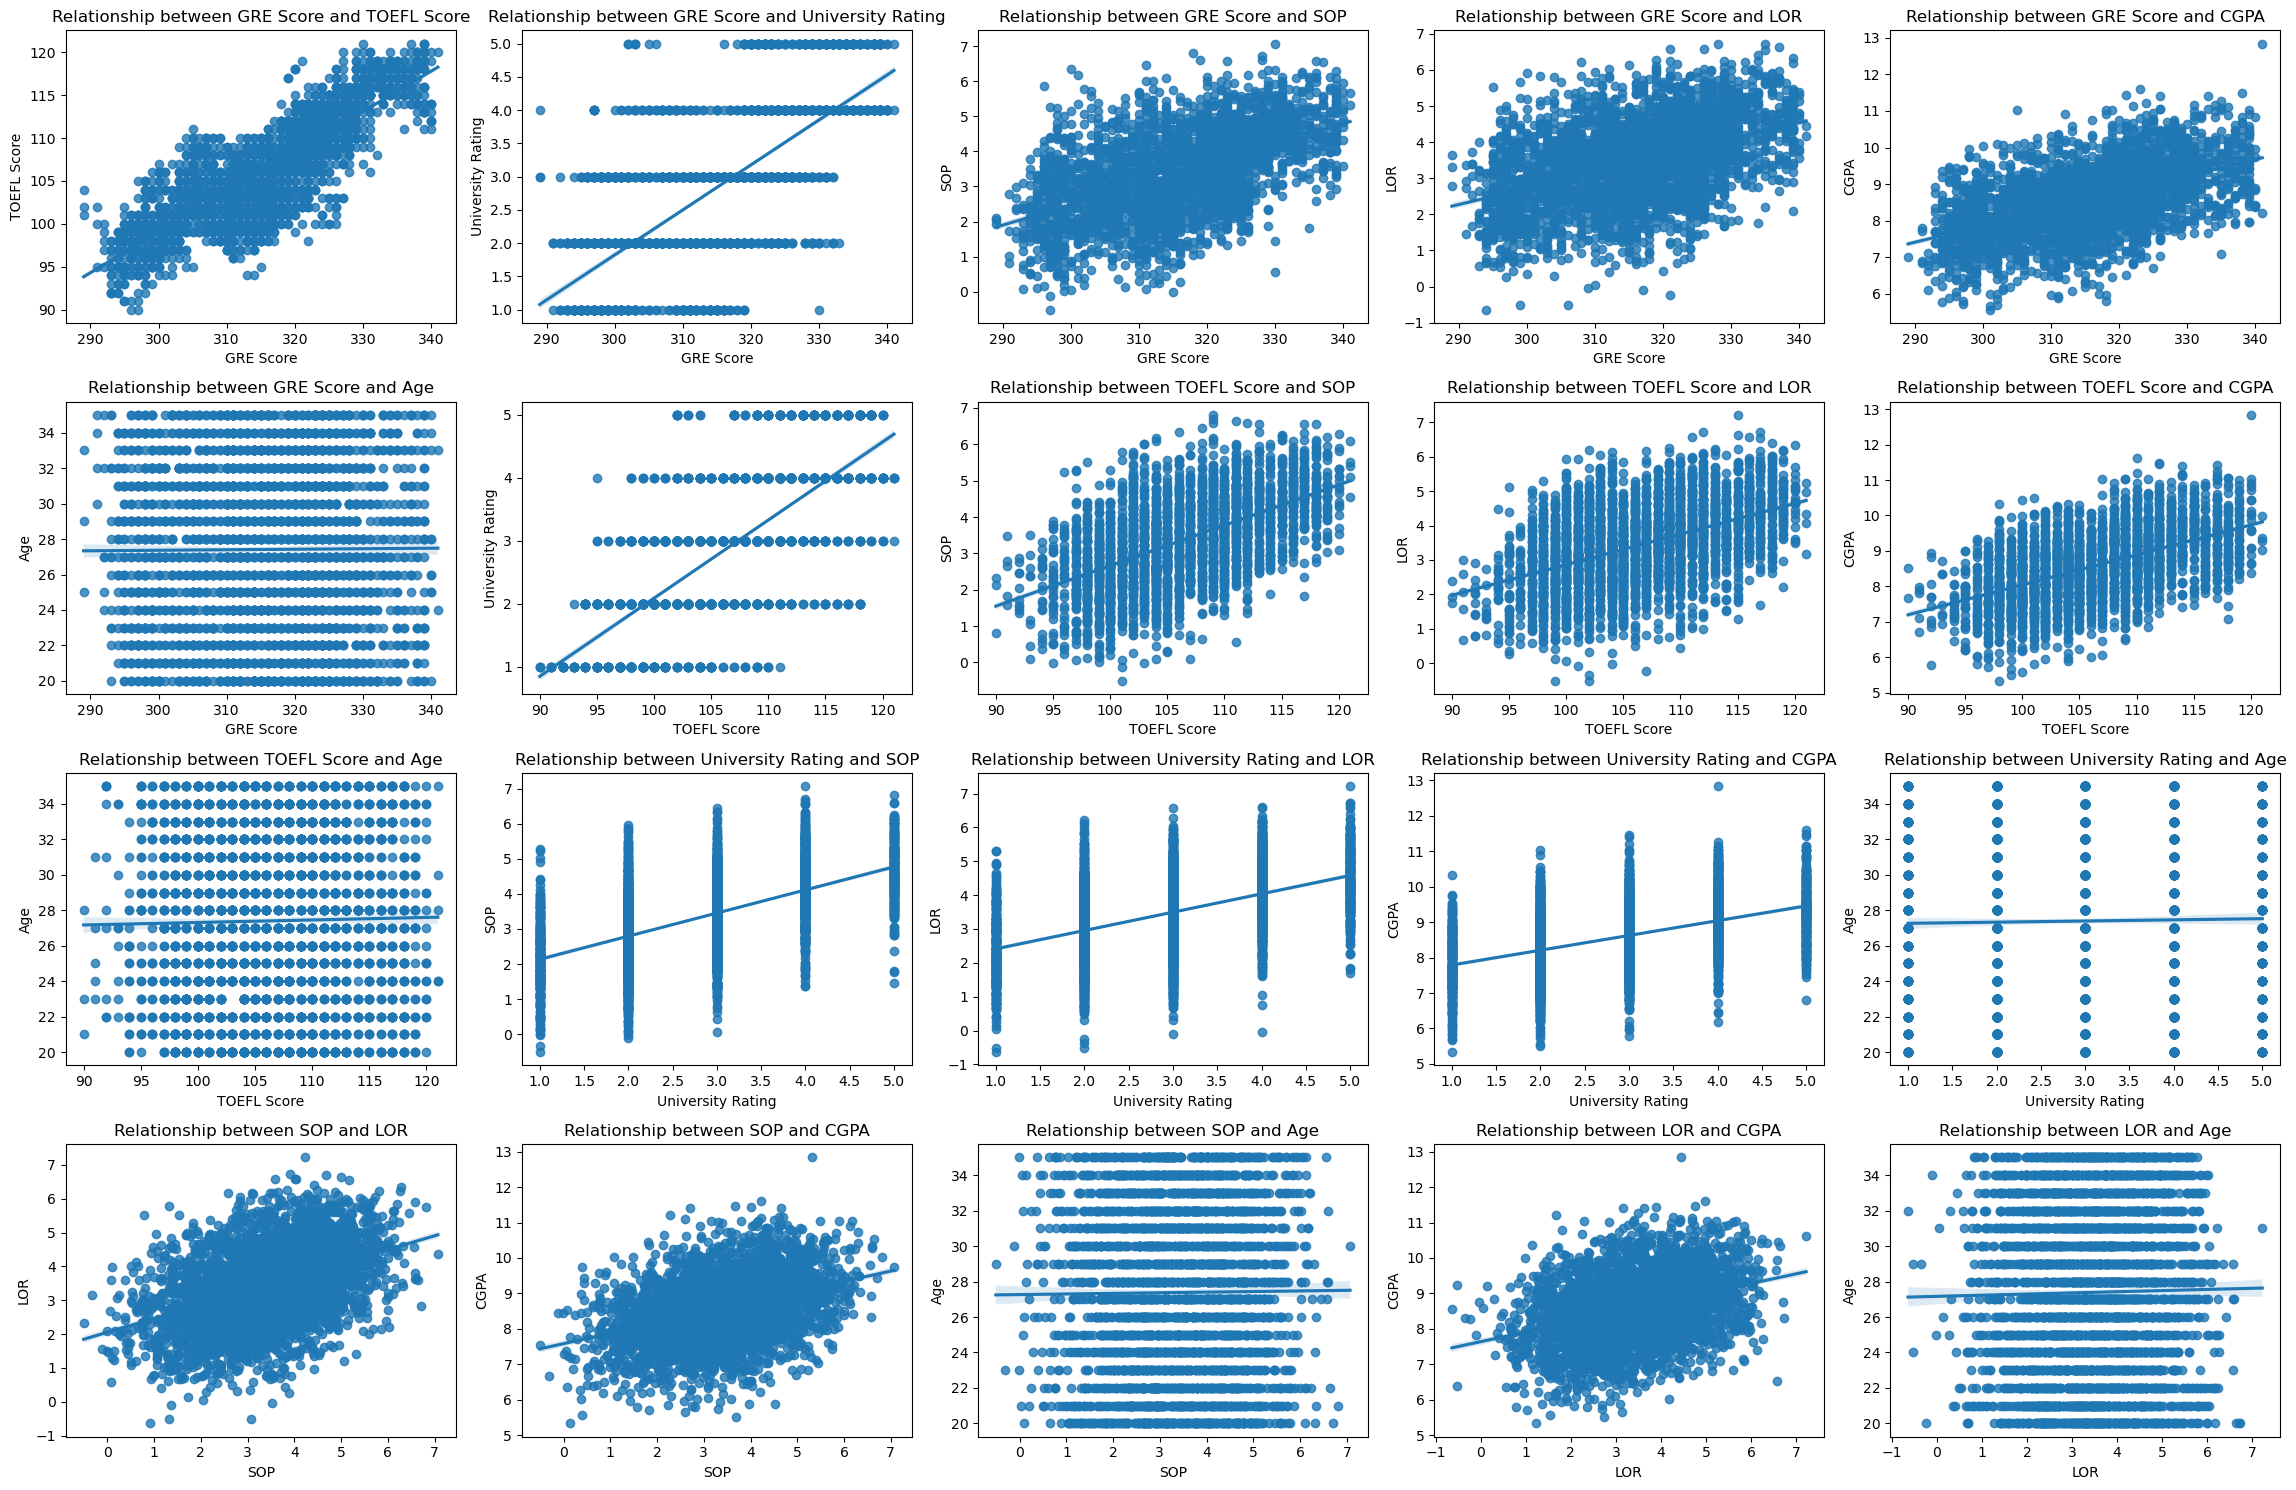

In [78]:
#Visualize the relationships between features
fig, axes = plt.subplots(4,5, figsize=(23,15))

sns.regplot(x="GRE Score", y="TOEFL Score", data=data1, ax=axes[0,0])
axes[0,0].set_xlabel("GRE Score")
axes[0,0].set_ylabel("TOEFL Score")
axes[0,0].set_title("Relationship between GRE Score and TOEFL Score")

sns.regplot(x="GRE Score", y="University Rating", data=data1, ax=axes[0,1])
axes[0,1].set_xlabel("GRE Score")
axes[0,1].set_ylabel("University Rating")
axes[0,1].set_title("Relationship between GRE Score and University Rating")

sns.regplot(x="GRE Score", y="SOP", data=data1, ax=axes[0,2])
axes[0,2].set_xlabel("GRE Score")
axes[0,2].set_ylabel("SOP")
axes[0,2].set_title("Relationship between GRE Score and SOP")


sns.regplot(x="GRE Score", y="LOR ", data=data1, ax=axes[0,3])
axes[0,3].set_xlabel("GRE Score")
axes[0,3].set_ylabel("LOR")
axes[0,3].set_title("Relationship between GRE Score and LOR")

sns.regplot(x="GRE Score", y="CGPA", data=data1, ax=axes[0,4])
axes[0,4].set_xlabel("GRE Score")
axes[0,4].set_ylabel("CGPA")
axes[0,4].set_title("Relationship between GRE Score and CGPA")

sns.regplot(x="GRE Score", y="Age", data=data1, ax=axes[1,0])
axes[1,0].set_xlabel("GRE Score")
axes[1,0].set_ylabel("Age")
axes[1,0].set_title("Relationship between GRE Score and Age")


#===========================================================================#
sns.regplot(x="TOEFL Score", y="University Rating", data=data1, ax=axes[1,1])
axes[1,2].set_xlabel("TOEFL Score")
axes[1,2].set_ylabel("University Rating")
axes[1,2].set_title("Relationship between TOEFL Score and University Rating")

sns.regplot(x="TOEFL Score", y="SOP", data=data1, ax=axes[1,2])
axes[1,2].set_xlabel("TOEFL Score")
axes[1,2].set_ylabel("SOP")
axes[1,2].set_title("Relationship between TOEFL Score and SOP")

sns.regplot(x="TOEFL Score", y="LOR ", data=data1, ax=axes[1,3])
axes[1,3].set_xlabel("TOEFL Score")
axes[1,3].set_ylabel("LOR")
axes[1,3].set_title("Relationship between TOEFL Score and LOR")

sns.regplot(x="TOEFL Score", y="CGPA", data=data1, ax=axes[1,4])
axes[1,4].set_xlabel("TOEFL Score")
axes[1,4].set_ylabel("CGPA")
axes[1,4].set_title("Relationship between TOEFL Score and CGPA")

sns.regplot(x="TOEFL Score", y="Age", data=data1, ax=axes[2,0])
axes[2,0].set_xlabel("TOEFL Score")
axes[2,0].set_ylabel("Age")
axes[2,0].set_title("Relationship between TOEFL Score and Age")

#==================================================================#

sns.regplot(x="University Rating", y="SOP", data=data1, ax=axes[2,1])
axes[2,1].set_xlabel("University Rating")
axes[2,1].set_ylabel("SOP")
axes[2,1].set_title("Relationship between University Rating and SOP")

sns.regplot(x="University Rating", y="LOR ", data=data1, ax=axes[2,2])
axes[2,2].set_xlabel("University Rating")
axes[2,2].set_ylabel("LOR")
axes[2,2].set_title("Relationship between University Rating and LOR")

sns.regplot(x="University Rating", y="CGPA", data=data1, ax=axes[2,3])
axes[2,3].set_xlabel("University Rating")
axes[2,3].set_ylabel("CGPA")
axes[2,3].set_title("Relationship between University Rating and CGPA")

sns.regplot(x="University Rating", y="Age", data=data1, ax=axes[2,4])
axes[2,4].set_xlabel("University Rating")
axes[2,4].set_ylabel("Age")
axes[2,4].set_title("Relationship between University Rating and Age")
#===============================================================================#

sns.regplot(x="SOP", y="LOR ", data=data1, ax=axes[3,0])
axes[3,0].set_xlabel("SOP")
axes[3,0].set_ylabel("LOR")
axes[3,0].set_title("Relationship between SOP and LOR")

sns.regplot(x="SOP", y="CGPA", data=data1, ax=axes[3,1])
axes[3,1].set_xlabel("SOP")
axes[3,1].set_ylabel("CGPA")
axes[3,1].set_title("Relationship between SOP and CGPA")

sns.regplot(x="SOP", y="Age", data=data1, ax=axes[3,2])
axes[3,2].set_xlabel("SOP")
axes[3,2].set_ylabel("Age")
axes[3,2].set_title("Relationship between SOP and Age")

#=======================================================================#

sns.regplot(x="LOR ", y="CGPA", data=data1, ax=axes[3,3])
axes[3,3].set_xlabel("LOR")
axes[3,3].set_ylabel("CGPA")
axes[3,3].set_title("Relationship between LOR and CGPA")

sns.regplot(x="LOR ", y="Age", data=data1, ax=axes[3,4])
axes[3,4].set_xlabel("LOR")
axes[3,4].set_ylabel("Age")
axes[3,4].set_title("Relationship between LOR and Age")

plt.tight_layout()
plt.show()
                     

#### The image above displays some interesting relationships between features in the data.
- Applicants with GRE scores tend to perform well on their TOEFL tests too
- It shows that applicants applying for top-ranking universities perform excellently on their GRE exams. This shows that applicants strive to perform well as these universities tends to pick students with very high GRE scores
- Applicants with high GRE and TOEFL score tend to have qualty SOP, LOR and a high CGPA
- The plots shows that Age is not a determining factor in whether a student gets admitted or not. The Age feature displays no interaction with other features


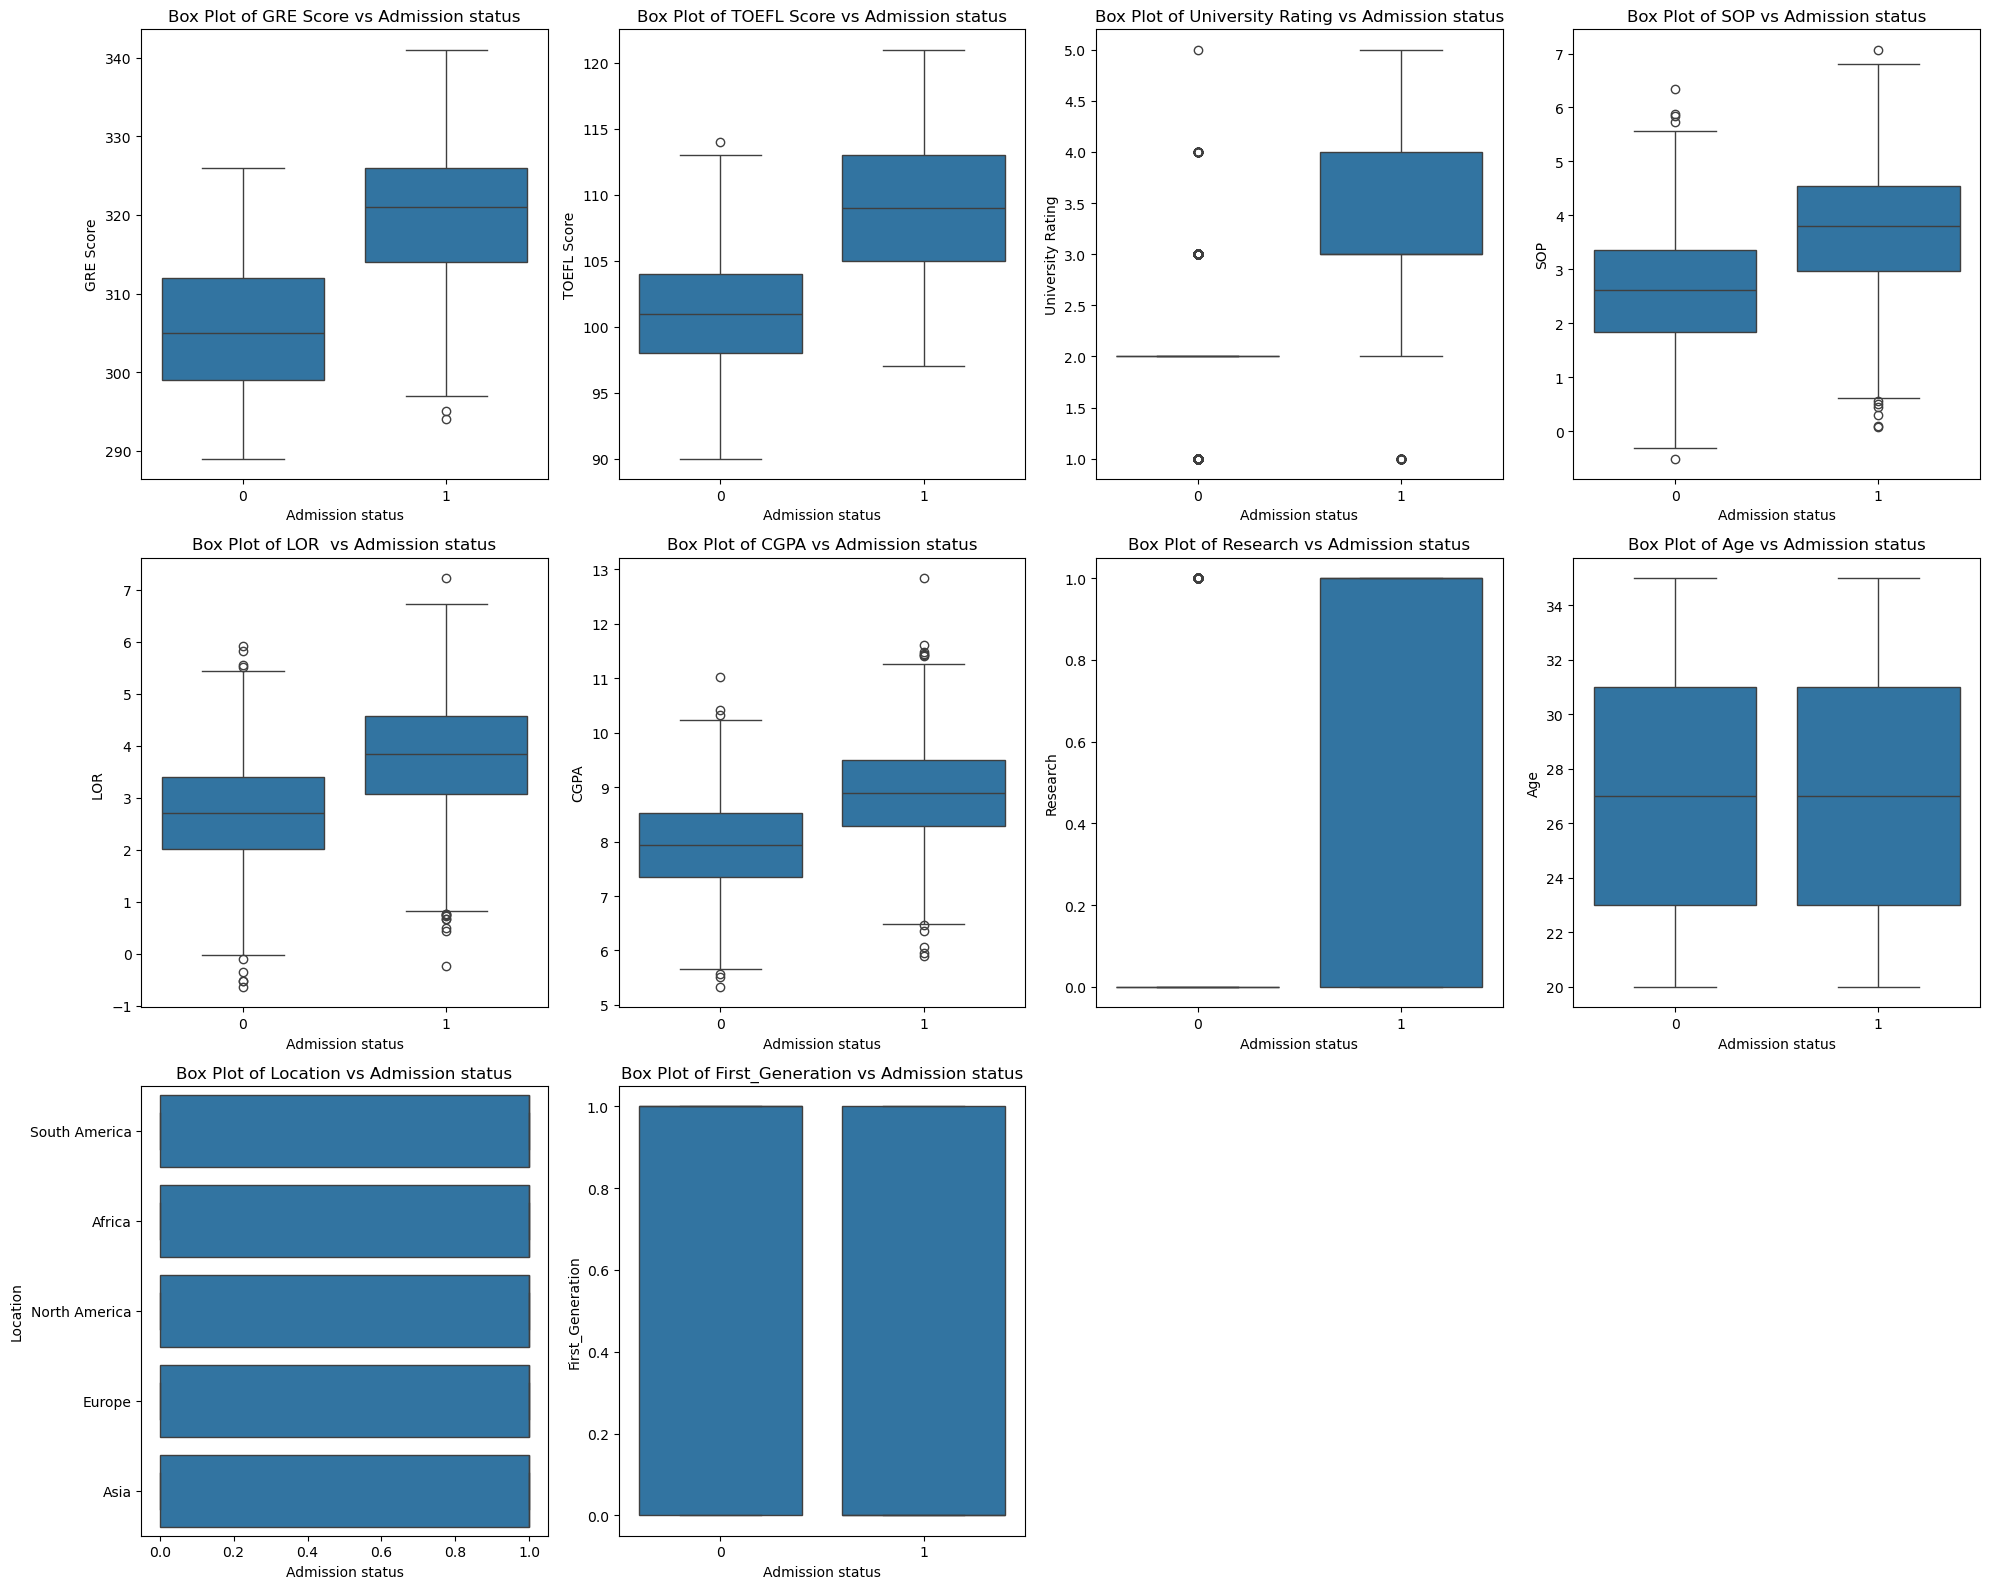

In [82]:
#visualize the relationship between features and target

numerical_features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ',
       'CGPA', 'Research', 'Age', 'Location', 'First_Generation']

fig,ax = plt.subplots(3,4,figsize=(20,16))
for i in range(len(numerical_features)):
    plt.subplot(3,4,i+1)
    sns.boxplot(x='Admitted', y=numerical_features[i], data=data1)
    plt.title('Box Plot of' +" "+ numerical_features[i] + " " + 'vs Admission status')
    plt.xlabel('Admission status')
    plt.ylabel(numerical_features[i])

for j in range(len(numerical_features), 12):
    ax.flatten()[j].axis('off')  
    
plt.tight_layout()
plt.show()

- Applicants who were admitted into graduate school tend to have higher GRE and TOEFL scores compared to applicants who weren't admitted.
- The data also shows that most applicants who were admitted chose schools of high ranking (3-4)
- Applicants who were admitted had better (SOP), better letter of recommendation(LOR) and a high CGPA compared to applicants who weren't admitted
- The data also shows us that research experience is an added advantage as it strengthens their application. Most applicants with Research experience were admitted.
- From the data, Age and location seems to have no effect on applicants admission status.


<Figure size 800x600 with 0 Axes>

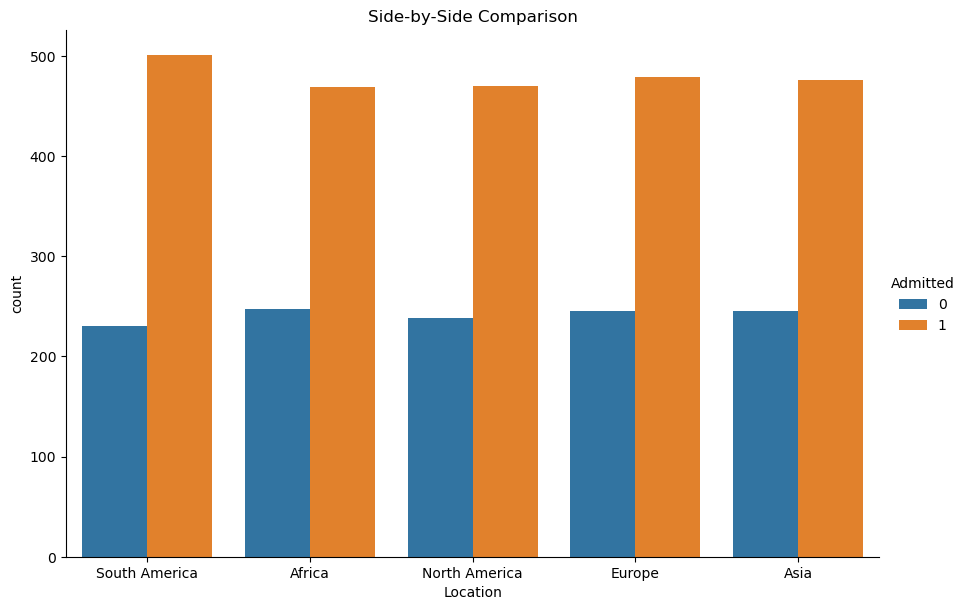

In [49]:
plt.figure(figsize=(8,6))
sns.catplot(x='Location', hue='Admitted', 
            kind='count', data=data1, height=6, aspect=1.5)
plt.title('Side-by-Side Comparison')
plt.show()

Although applicants admitted into graduate school are more compared to non-admitted applicants in each location. There is no considerable difference to tell if the location of applicants favour more admission to grad school

<Figure size 800x600 with 0 Axes>

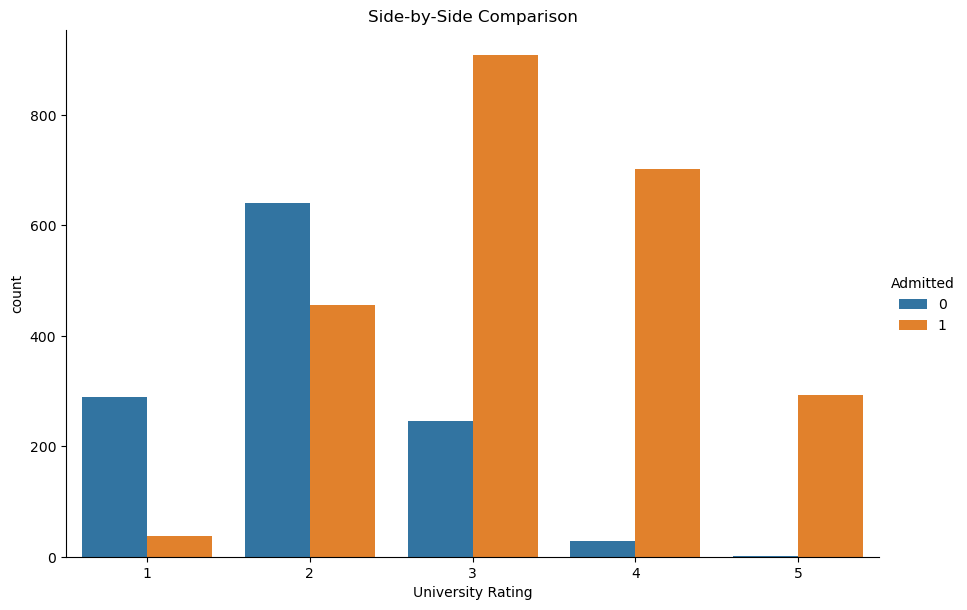

In [49]:
plt.figure(figsize=(8,6))
sns.catplot(x='University Rating', hue='Admitted', 
            kind='count', data=data1, height=6, aspect=1.5)
plt.title('Side-by-Side Comparison')
plt.show()

The data shows that most successful applicants applied to universities with high ranking. 

<Figure size 800x600 with 0 Axes>

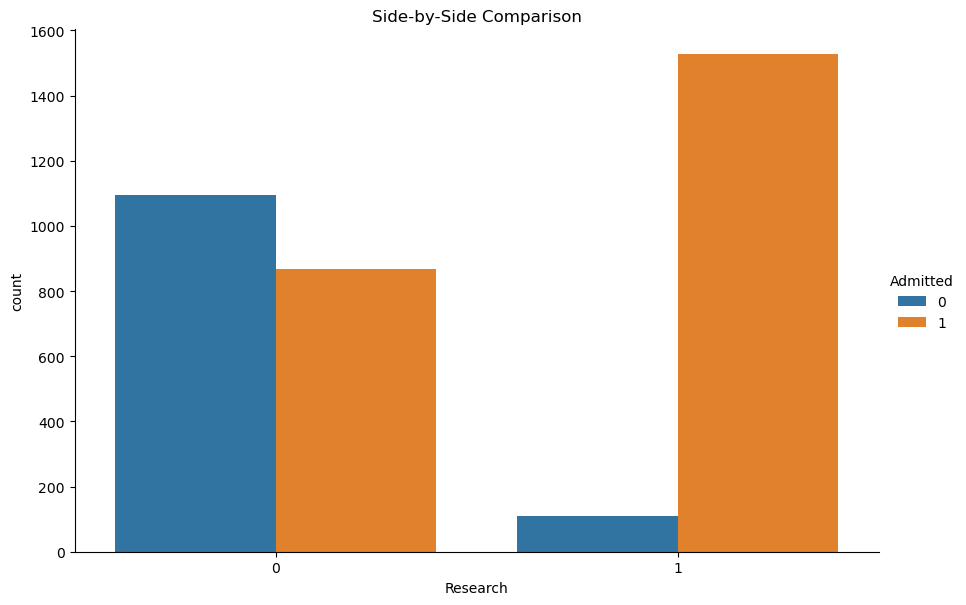

In [51]:
plt.figure(figsize=(8,6))
sns.catplot(x='Research', hue='Admitted', 
            kind='count', data=data1, height=6, aspect=1.5)
plt.title('Side-by-Side Comparison')
plt.show()

>#### HeatMap Correlation

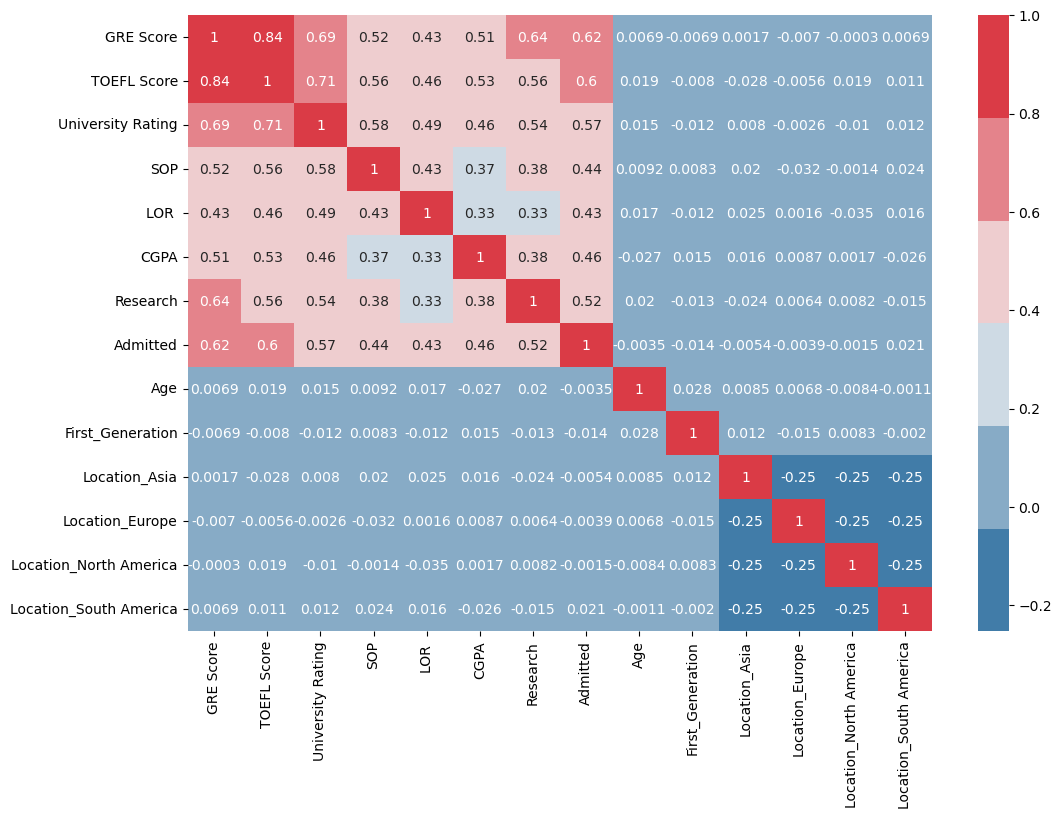

In [41]:
#create a copy of data1
eda_data = data1.copy()
eda_data = eda_data.drop(["ID"], axis=1)
#encode categorical feature
eda_data = pd.get_dummies(eda_data, columns=["Location"], drop_first=True)
plt.figure(figsize=(12,8))
sns.heatmap(data=eda_data.corr(),annot=True, cbar=True, cmap=sns.diverging_palette(240,10))
plt.show()

All features except location and Age seem to have a positive correlation with applicants admission status. The plot tells us that admission into graduate school is independent of Age and Location

# Data Preprocessing

>#### During EDA, it was noticed that some aplicants had unsual values for some of the input features. For example some applicants were having scores greater than the maximum score attainable in GRE.

In [93]:
#Replace cgpa values>10 with 10, toefl score>120 with 120, sop>5 with 5, lor>5 with 5, and gre score>340 with 340

train_data = data1.copy()
test_data = data2.copy()

capping_rules = {
    "GRE Score":340,
    "TOEFL Score":120,
    "SOP":5,
    "LOR ":5,
    "CGPA":10
}

for col,max_val in capping_rules.items():
    train_data[col] = train_data[col].clip(upper=max_val)
    test_data[col] = test_data[col].clip(upper=max_val)

In [95]:
#Replace negative and zero values with 1

replace_rules = {
    "SOP":1,
    "LOR ":1
}

for column,min_val in replace_rules.items():
    train_data[column] = train_data[column].clip(lower=min_val)
    test_data[column] = test_data[column].clip(lower=min_val)

#### Handling Missing Values

Iterative Imputer was used to fill the missing values because it models missing values as a function of other features using regression (e.g predicts missing CGPA for an applicant based on  their GRE scores, SOP, etc.), preserving the pattern and spread of the data. This is better than just filling missing values with the mean values from all applicants.

In [100]:
#Replace missing values using  iterative imputer
missing_features = ["GRE Score","TOEFL Score","SOP","CGPA"]
imputer = IterativeImputer(max_iter=30, random_state=11)
# Impute missing values
train_data[missing_features] = imputer.fit_transform(train_data[missing_features])
test_data[missing_features] = imputer.transform(test_data[missing_features])

In [150]:
#drop features that are not needed for training
target = train_data["Admitted"]
train = train_data.drop(["ID","Admitted","Age","Location", "First_Generation"], axis=1)
test = test_data.drop(["ID","Age","Location", "First_Generation"], axis=1)

In [152]:
#Mutual information gives a sense of what features are important at predicting if students get admitted or not
from sklearn.feature_selection import mutual_info_classif

#create a copy of the train_data
X_ft = train.copy()
y_tg = target 


# Calculate mutual information
mi_scores = mutual_info_classif(X_ft, y_tg, random_state=50)
mi_scores = pd.Series(mi_scores, index=X_ft.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

GRE Score            0.254340
TOEFL Score          0.223429
University Rating    0.201439
Research             0.149052
SOP                  0.118221
CGPA                 0.110012
LOR                  0.097430
dtype: float64


In [154]:
train.shape, test.shape, target.shape

((3600, 7), (900, 7), (3600,))

>## Features Engineering

In [157]:
#weighted average of the standardised test scores
train['academic_strength'] = 0.8 * train['GRE Score'] + 0.2 * train['TOEFL Score'] 
test['academic_strength'] = 0.8 * test['GRE Score'] + 0.2 * test['TOEFL Score']
#=====================================================================================================
#Feature interaction between GRE scores and university rating
train['Gre_university'] = train['GRE Score'] * train['University Rating']
test['Gre_university'] = test['GRE Score'] * test['University Rating']
#=====================================================================================================
#Research strength of applicants
train['Research_strength'] = train['Research'] + (train['SOP'] + train['LOR '] + train['CGPA'] + train['GRE Score'])
test['Research_strength'] = test['Research'] + (test['SOP'] + test['LOR '] + test['CGPA'] + test['GRE Score'])
#=====================================================================================================

># Model Development

In [160]:
train.shape, test.shape, target.shape

((3600, 10), (900, 10), (3600,))

In [162]:
# calculate the class weight for each class
class_weights = calculate_class_weights(target)
print(class_weights)

{0: 1.4937759336099585, 1: 0.7515657620041754}


In [164]:
#split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.1, random_state=23, stratify=target) #best 23

In [166]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3240, 10), (360, 10), (3240,), (360,))

In [168]:
class_names = ['Not Admitted 0', 'Admitted 1']

In [170]:
#xgboost stratified kfold cross validation

xgboost_model = xgb.XGBClassifier(reg_lambda= 10, reg_alpha=1, n_estimators=1443, min_samples_split=6, max_depth=11, learning_rate=0.014,
                                  class_weights=class_weights,random_state=20)
mean_f1_xgboost = stratified_kfold_cv(xgboost_model, X_train, y_train, n_splits=5,
                                           class_weights=class_weights, verbose=True) 
# Print the mean F1-score across folds
print(f"Mean F1-Score across folds (XgBoost): {mean_f1_xgboost:.4f}")

Fold 1/5
F1 Score: 0.9046
Fold 2/5
F1 Score: 0.9085
Fold 3/5
F1 Score: 0.9068
Fold 4/5
F1 Score: 0.8902
Fold 5/5
F1 Score: 0.8974
Mean F1 Score: 0.9015
Mean F1-Score across folds (XgBoost): 0.9015


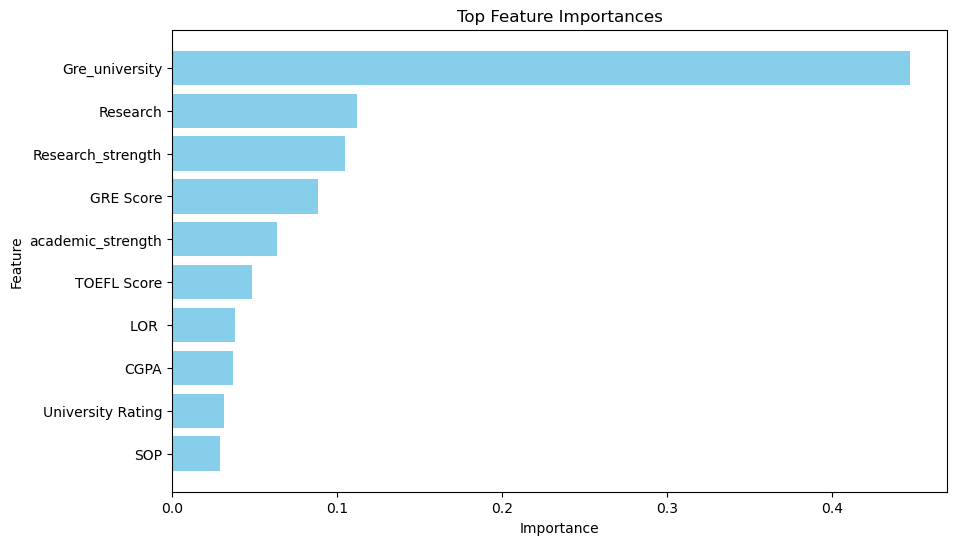

In [125]:
visualize_feature_importance(xgboost_model, X_train.columns)

In [172]:
xgboost_model.fit(X_train, y_train)
xgboost_val_pred = xgboost_model.predict(X_val)
print(classification_report(y_val, xgboost_val_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       120
           1       0.89      0.90      0.89       240

    accuracy                           0.86       360
   macro avg       0.84      0.84      0.84       360
weighted avg       0.86      0.86      0.86       360



In [174]:
xgb_f1_score = f1_score(y_val, xgboost_val_pred)
xgb_acc_score = accuracy_score(y_val, xgboost_val_pred)
xgb_auc_score = roc_auc_score(y_val, xgboost_val_pred)

print(f"F1 Score: {xgb_f1_score:.4f}")
print(f"AUC Score: {xgb_auc_score:.4f}")
print(f"Accuracy Score: {xgb_acc_score:.4f}")

F1 Score: 0.8940
AUC Score: 0.8396
Accuracy Score: 0.8583


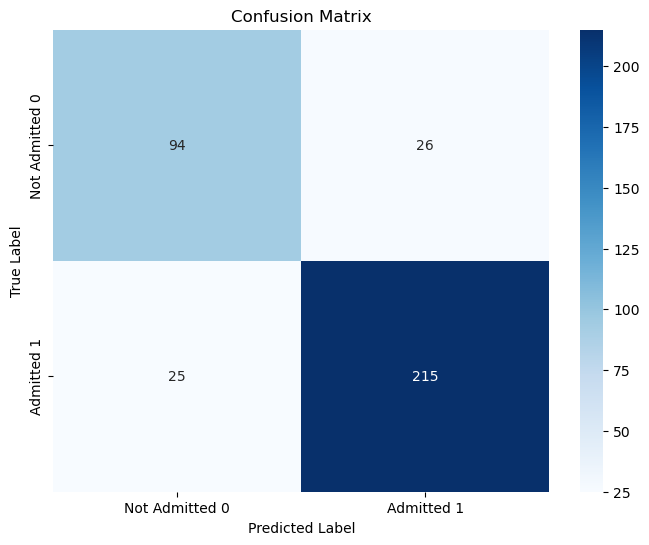

In [139]:
plot_confusion_matrix(y_val, xgboost_val_pred, class_names)

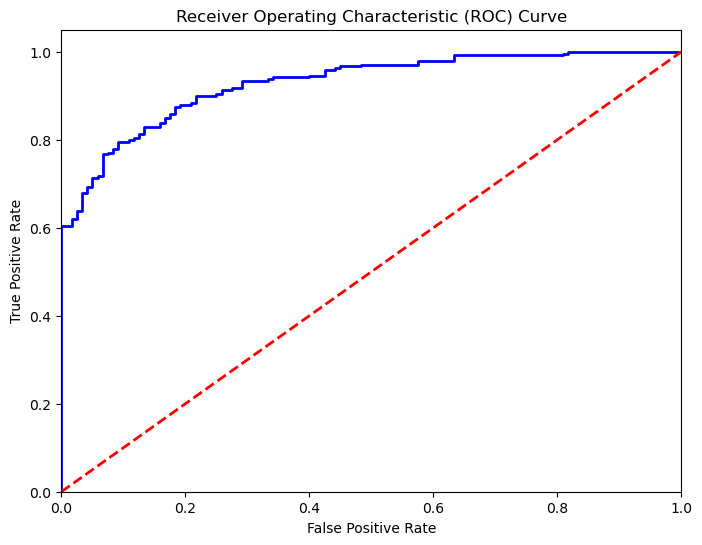

In [141]:
# plot ROC curve
y_prob = xgboost_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
     

The feature importance plots show that **Gre_university** was an important feature for the model in predicting the application status of students.

**After training and validation:**
>The model achieved strong performance with an 89.4% F1-score, demonstrating excellent balance between precision and recall in classifying admission status fpr applicants. An 85.83% accuracy indicates robust overall prediction correctness, while the 83.96% AUC-ROC score confirms good (though not perfect) ability to distinguish between admitted and rejected applicants. Together, these metrics suggest the model is highly reliable for identifying successful candidates while maintaining reasonable discrimination across probability thresholds.

In [176]:
xgb_preds = xgboost_model.predict(test)
ss = sub.copy()
ss['Admitted'] = xgb_preds
ss.to_csv('fsub_xgb.csv', index=False) 
print('saved!')
ss.head()

saved!


,ID,Admitted
0,ID_003601,1
1,ID_003602,1
2,ID_003603,0
3,ID_003604,1
4,ID_003605,1


In [ ]:
#from joblib import dump

#dump(model, 'xgboost_model.joblib') 
#loaded_model = load('xgboost_model.joblib')